## Necessary Imports

In [27]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv
import os
from groq import Groq
from langchain_groq import ChatGroq
import ipywidgets as widgets
from IPython.display import display, HTML
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import chain
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.chains import LLMChain
from langchain_core.documents import Document
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from langchain_chroma import Chroma
from uuid import uuid4
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain.retrievers import BM25Retriever, EnsembleRetriever

#### This is the simple RAG framework and for our purposes we will break this down into a three step process: indexing, retrieval and generation.

## Indexing

### Loading Documents
The project uses the following books as the primary data sources for retrieval and generation:
1. "Verity" by Colleen Hoover
    - Genre: Psychological Thriller

    - Description: A gripping novel about a struggling writer, Lowen Ashleigh, who is hired to complete the remaining books in a successful series by the injured author, Verity Crawford. As Lowen works on the manuscripts, she uncovers dark secrets about Verity's life.

    - Use Case: The book's complex narrative and character dynamics make it an excellent source for testing retrieval and generation capabilities.

2. "The Girl on the Train" by Paula Hawkins
    - Genre: Mystery, Thriller

    - Description: A suspenseful story about Rachel, a woman who becomes entangled in a missing persons investigation that she observes during her daily train commute. The novel explores themes of memory, truth, and deception.

    - Use Case: The intricate plot and unreliable narration provide rich content for testing advanced RAG techniques.

In [3]:
def load_pdf(file_path, min_text_length=0):
    """Load PDF file and filter out pages with content shorter than min_text_length.
    
    Args:
        file_path: str - Path to PDF file
        min_text_length (default=0): int - Minimum character length for page content
    
    Returns:
        List[Document] - List of filtered document pages
    """
    pdf_file = PyMuPDFLoader(file_path)  # Using PyMuPDF for metadata-rich loading
    pdf_pages = pdf_file.load()
    
    # Filter out pages with content <= min_text_length (including empty/whitespace)
    return [page for page in pdf_pages if len(page.page_content.strip()) > min_text_length]


In [4]:
verity_book = load_pdf("./Dataset/Verity-By-Colleen-Hoover.pdf")
tgott_book = load_pdf("./Dataset/The-Girl-on-the-Train.pdf")

### Text Splitting
We will use sementic chunking in below mentioned manner and we will modify metadata for filtering.
- Recursive Character Text Splitter => Semantic Chunking => Add Hypothetical Questions in metadata

#### Recursive Character Text Splitting

In [6]:
def recursive_text_splitting(documents):
    """Split documents recursively into smaller chunks with metadata preservation.
    
    Args:
        documents: List[Document] - Input documents to split
    
    Returns:
        List[Document] - List of document chunks with preserved metadata
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,       # Optimal size for many LLM applications
        chunk_overlap=16,      # Small overlap to maintain context
        add_start_index=True,  # Preserve original document positions
        strip_whitespace=True  # Clean whitespace artifacts
    )
    return splitter.split_documents(documents)

In [7]:
verity_book_recursive_chunks = recursive_text_splitting(verity_book)
tgott_book_recursive_chunks = recursive_text_splitting(tgott_book)

In [8]:
verity_book_recursive_chunks[10].metadata

{'producer': 'calibre 3.33.1 [https://calibre-ebook.com]',
 'creator': 'calibre 3.33.1 [https://calibre-ebook.com]',
 'creationdate': '2018-12-13T14:15:10+00:00',
 'source': './Dataset/Verity-By-Colleen-Hoover.pdf',
 'file_path': './Dataset/Verity-By-Colleen-Hoover.pdf',
 'total_pages': 223,
 'format': 'PDF 1.4',
 'title': 'Verity',
 'author': 'Colleen Hoover',
 'subject': '',
 'keywords': '',
 'moddate': '',
 'trapped': '',
 'modDate': '',
 'creationDate': "D:20181213141510+00'00'",
 'page': 7,
 'start_index': 0}

In [9]:
print(len(verity_book_recursive_chunks))
print(len(tgott_book_recursive_chunks))

1056
1224


#### Semantic Chunking
Isn't it weird that we have a global constant for chunk size? Isn't it even weirder that our normal chunking mechanisms don't take into account the actual content?

There has to be a better way - let's explore and find out.

Embeddings represent the semantic meaning of a string. They don't do much on their own, but when compared to embeddings of other texts you can start to infer the relationship between chunks. I want to lean into this property and explore using embeddings to find clusters of semantically similar texts.

The hypothesis is that semantically similar chunks should be held together.

- Find break points between sequential sentences - Next up I tried a walk method. I started at the first sentence, got the embedding, then compared it to sentence #2, then compared #2 and #3 and so on. I was looking for "break points" where embedding distance was large. If it was above a threshold, then I considered it the start of a new semantic section. I originally tried taking embeddings of every sentence, but this turned out to be too noisy. So I ended up taking groups of 3 sentences (a window), then got an embedding, then dropped the first sentence, and added the next one. This worked out a bit better.


In [10]:
# Semantic Chunking with Position-Aware Embeddings
embedder = HuggingFaceEmbeddings(model_name="BAAI/llm-embedder")

In [11]:
def semantic_chunking_visualization(recursive_chunks, threshold):
    """Visualize semantic chunk boundaries based on embedding distances.
    
    Args:
        recursive_chunks: List[Document] - Chunks from recursive text splitting
    
    Returns:
        List[int] - Indices of detected breakpoints
    """
    # Generate embeddings and calculate distances
    embeddings = embedder.embed_documents([c.page_content for c in recursive_chunks])
    distances = [1-cosine_distances([embeddings[i]], [embeddings[i+1]])[0][0] 
                for i in range(len(embeddings)-1)]
    
    # Calculate breakpoints (eg: 95th percentile threshold)
    threshold = np.percentile(distances, threshold)
    breakpoints = [i for i, d in enumerate(distances) if d > threshold]
    
    # Setup visualization
    plt.figure(figsize=(15, 5))
    y_min, y_max = min(distances), max(distances)
    
    # Plot distances and threshold
    plt.plot(distances)
    plt.axhline(threshold, color='r', linestyle='--')
    plt.ylim(y_min, y_max)
    plt.xlim(0, len(distances)) 

    # Then we'll see how many distances are actually above this one
    num_distances_above_theshold = len(breakpoints) # The amount of distances above your threshold
    plt.text(x=(len(distances)*.01), y=y_max+.003, s=f"{num_distances_above_theshold + 1} Chunks")
    
    # Annotate chunks
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    prev_bp = 0
    for i, bp in enumerate(breakpoints):
        plt.axvspan(prev_bp, bp, facecolor=colors[i%len(colors)], alpha=0.25)
        plt.text((prev_bp+bp)/2, y_min, f"Chunk {i+1}", 
                ha='center', va='bottom', rotation=90)
        prev_bp = bp
    
    # Handle final chunk
    if breakpoints and breakpoints[-1] < len(distances):
        plt.axvspan(breakpoints[-1], len(distances),
                   facecolor=colors[len(breakpoints)%len(colors)], alpha=0.25)
        plt.text((breakpoints[-1]+len(distances))/2, y_min, f"Chunk {len(breakpoints)+1}",
                ha='center', va='bottom', rotation=90)
    
    plt.title("Semantic Chunk Boundaries")
    plt.xlabel("Sentence Position")
    plt.ylabel("Cosine Distance")
    plt.show()
    
    return breakpoints

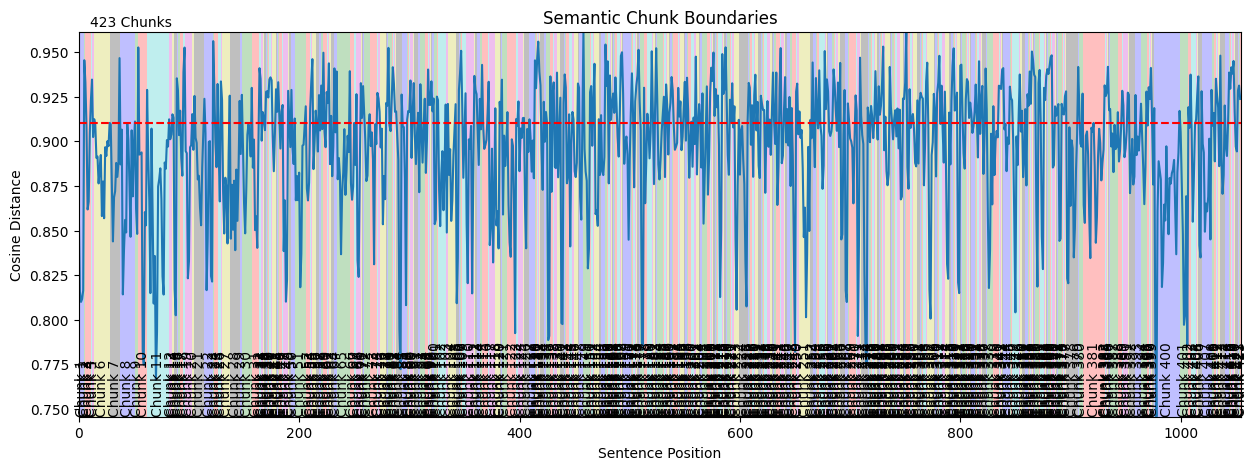

In [40]:
verity_book_breakpoints = semantic_chunking_visualization(verity_book_recursive_chunks, 60)

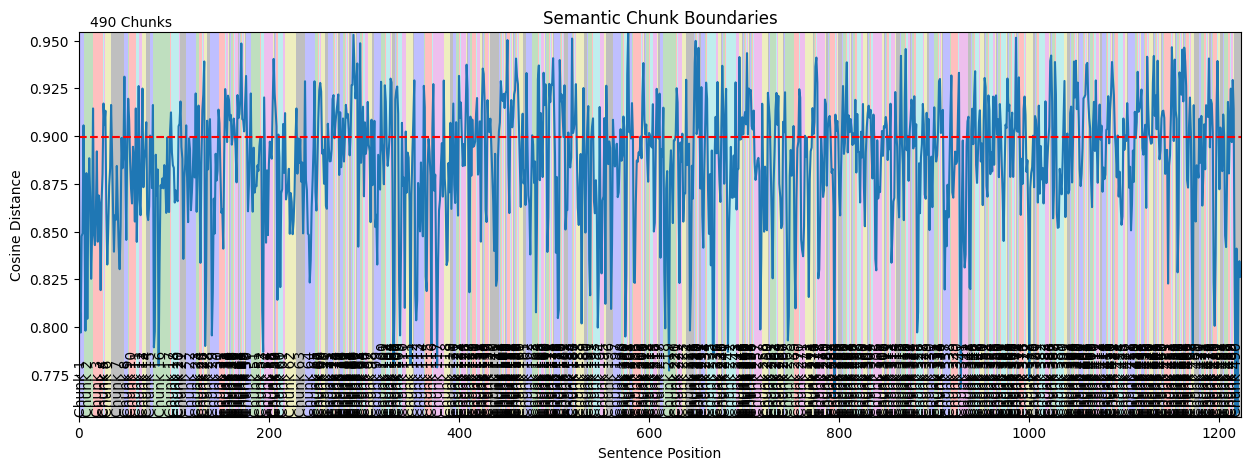

In [41]:
tgott_book_breakpoints = semantic_chunking_visualization(tgott_book_recursive_chunks, 60)

Hm, cool! It's interesting to see sections where distances are smaller and then areas of larger distances. What stands out to me most is the outliers which are spread out.

There are many ways to chunk up the essay based off these distances, but I considered any distance above the 75th percentile of distances as a break point. This is the only parameter we'll need to config.

Well now that we've succefully distracted ourselves with a visualization, now we need to combine the sentences into chunks.


In [42]:
def semantic_chunking(breakpoints, recursive_chunks):
    """Combine document chunks into semantic groups using detected breakpoints.
    
    Args:
        breakpoints: List[int] - Indices where semantic breaks occur
        recursive_chunks: List[Document] - Original text chunks
        
    Returns:
        List[Document] - New chunks with combined content and aggregated metadata
    """
    final_chunks = []
    start_idx = 0
    
    # Add a sentinel breakpoint at the end to handle final chunk
    all_breakpoints = sorted(breakpoints) + [len(recursive_chunks) - 1]
    
    for end_idx in all_breakpoints:
        # Get chunks in current range
        current_chunks = recursive_chunks[start_idx:end_idx+1]
        
        # Combine content and collect metadata
        combined_text = " ".join(str(chunk.page_content) for chunk in current_chunks)
        
        # Aggregate metadata from all chunks
        pages = " ".join(str(chunk.metadata.get("page")) for chunk in current_chunks)
        first_chunk = current_chunks[0]
        combined_metadata = {
            "source": first_chunk.metadata.get("source"),
            "pages": pages,
            "propositions": len(current_chunks),
            "total_pages": first_chunk.metadata.get("total_pages"),
            "title": first_chunk.metadata.get("title"),
            "author": first_chunk.metadata.get("author")
        }
        
        final_chunks.append(Document(
            page_content=combined_text,
            metadata=combined_metadata
        ))
        
        start_idx = end_idx + 1
    
    return final_chunks

In [43]:
verity_book_final_chunks = semantic_chunking(verity_book_breakpoints, verity_book_recursive_chunks)

In [44]:
tgott_book_final_chunks = semantic_chunking(tgott_book_breakpoints, tgott_book_recursive_chunks)

In [45]:
verity_book_final_chunks[0]

Document(metadata={'source': './Dataset/Verity-By-Colleen-Hoover.pdf', 'pages': '2 2 3 4 5 6', 'propositions': 6, 'total_pages': 223, 'title': 'Verity', 'author': 'Colleen Hoover'}, page_content='Copyright © 2018 by Colleen Hoover\nAll rights reserved. No part of this publication may be reproduced, distributed,\nor transmitted in any form or by any means, including photocopying, recording,\nor other electronic or mechanical methods, without the prior written permission\nof the publisher, except in the case of brief quotations embodied in critical\nreviews and certain other noncommercial uses permitted by copyright law.\nThis book is a work of fiction. All names, characters, locations, and incidents are products of the authors’ imaginations. Any resemblance to actual persons, things,\nliving or dead, locales, or events is entirely coincidental.\nVERITY\nEditing by Murphy Rae\nCover Design by Murphy Rae\nInterior Formatting by Elaine York, Allusion Graphics, LLC Chapter One\nChapter Two\

### Creating Embedding and Storing Text to Vector DB

In [46]:
# Create vector store
vector_store = Chroma(
    collection_name="Adavance_RAG_Test",
    embedding_function=embedder,
    persist_directory="./Dataset/chroma_db_langchain",  # Where to save data locally, remove if not necessary
)

In [52]:
# vector_store.delete(ids=verity_book_uuids)
# vector_store.delete(ids=tgott_book_uuids)

In [ ]:
verity_book_uuids = [str(uuid4()) for _ in range(len(verity_book_final_chunks))]
tgott_book_uuids = [str(uuid4()) for _ in range(len(tgott_book_final_chunks))]

In [54]:
vector_store.add_documents(documents=verity_book_final_chunks, ids=verity_book_uuids)

['d4dbf5b9-a7b1-4ef8-8fca-177ec1c87a26',
 '5dedd144-2e80-4bb7-b5a9-76863d4d515e',
 'b3822c2e-c457-40f6-bcac-f364e91a53ce',
 '6c812f07-1630-40d8-906d-1353f0646207',
 'd1b3ed06-72a4-4353-b4a5-939d1ba35335',
 '826d0ecd-01ef-40a9-ae06-d6fd267738e2',
 '571c3ad6-a89a-4c5d-a01a-027159bc5379',
 'd42cdcfe-31b2-47e8-91e9-bece9b0123da',
 'f87819e2-adbd-46f5-baa8-8763451dad23',
 'e04ec39f-89f8-4c6c-8354-cc2a4e007994',
 'd21a6bb4-ed28-4742-9507-b728dc80c88d',
 '8195259f-92b6-473a-860d-146984327dfd',
 '5832276f-b8ed-4235-b48c-011272574ada',
 'a6c5e1c9-8a54-4a27-ae4d-1d4883a18b85',
 '959cd564-6b73-42dd-8aaa-448fce9bbb78',
 '9370c0fc-5a9a-4cb5-82c7-7e61754945ab',
 '07419e0d-9a96-4845-b17e-74c31e7d55fc',
 'b1e6fcb3-b0a7-46f1-b8e8-d997bae7b53c',
 '9f166264-6479-44f4-9fa0-fb89dee7e985',
 '707daa84-8555-4c4c-9e94-71128ff7da97',
 '394da2f5-c13e-4145-bdf1-b8957132dc73',
 '12eeecc6-71f0-488f-bb46-9e07589cbdd0',
 '3ceedce9-dea7-4942-8dc3-f027b5688155',
 '989d4cbe-8b06-4efc-8d98-2860307faaaf',
 'c9d395e8-d407-

In [55]:
vector_store.add_documents(documents=tgott_book_final_chunks, ids=tgott_book_uuids)

['ddc605d3-11f5-4d1d-b077-5a67416bbe6d',
 '9e64fce3-2e43-475f-b6c8-c4dd17406a4f',
 '48e76818-47bc-42a3-92d4-2cdaa44af441',
 '81147e92-c6b2-4f84-9d67-b5566bb95ee0',
 '567d0508-2fe7-4895-97b4-ddf4c6d68ca0',
 'b047c1dc-5a6f-4c6a-abbd-e011d4b1fbc1',
 '22251fe7-5231-4ec4-b7c2-a1fceb10b26d',
 '4eceae89-cdf7-4f8e-87a9-d9eed5bdba25',
 'fabe2006-aea3-4057-ba80-87f44ff2e2c9',
 '9c3c48cb-b2e1-4ccb-b405-a280989ff86e',
 'e8d8ef55-db90-4d68-90e5-95bbc32c7505',
 'd2a01bf4-be69-43ca-8793-5cea6ceecc73',
 'fa1d5e2e-fe93-4602-beaf-77404842024e',
 'd74ab42e-70d0-4681-81a4-d88e1f488f9c',
 '85786777-fe56-40db-b0fd-f89374737449',
 'f50f77d5-61ee-4549-a02f-e13f070e4ea4',
 '591151b7-2360-4d6e-9c5d-ce68dcd1cd8d',
 'dc98ca3f-d11d-488e-9815-bad4313464cd',
 '14009f56-0ddf-40e9-9b6b-dba2c864b414',
 'b0f194c6-e76e-4753-8e10-76c3b11ce09a',
 'be764ce2-9c35-43be-b4b2-9e7bb42b9c39',
 '049f9d3d-0d8f-40d9-9476-64f35aef5e4f',
 'adb854c3-5109-47a9-93af-1452435ee2ca',
 'fc4c007e-2e15-433d-a897-8b71d0affc0a',
 '9eafe716-8f87-

In [57]:
vector_store.get_by_ids([ 'f451884f-e033-404e-b68f-e771329081d9',])

[Document(id='f451884f-e033-404e-b68f-e771329081d9', metadata={'author': 'Colleen Hoover', 'pages': '221', 'propositions': 1, 'source': './Dataset/Verity-By-Colleen-Hoover.pdf', 'title': 'Verity', 'total_pages': 223}, page_content='doesn’t leave room for Sasha to step on with us. He blocks the doorway and\nwe’re forced to face the direction of the doors. The direction of Sasha. He hits\nthe button for the lobby and when the doors begin to close, I finally look up.\nI notice two things.\n1)  Ethan is no longer in the hallway and his apartment door is closed.\n2)  Sasha is so much prettier than me. Even when she’s crying.\nThe doors close and it’s a long, quiet ride to the bottom. Graham doesn’t let')]

## Retrieval
In hybrid search - a keyword-sensitive semantic search approach, we combine vector search and keyword search algorithms to take advantage of their respective strengths while mitigating their respective limitations.

For semantic matching, we use the vector_store as retriever from Langchain. By setting k to 3, we’re asking the retriever to return the 3 most relevant documents or vectors from the vector store.

In [85]:
vectordb_retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 7})
vectordb_retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x0000019218407700>, search_kwargs={'k': 7})

For keyword matching, we use the BM25 retriever from Langchain. By setting k to 3, we’re asking the retriever to return the 3 most relevant documents or vectors from the vector store.

In [86]:
keyword_retriever = BM25Retriever.from_documents(verity_book_final_chunks+tgott_book_final_chunks)
keyword_retriever.k =  7
keyword_retriever

BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x000001921886F400>, k=7)

Now, we create the ensemble retriever, which is a weighted combination of the keyword and semantic retrievers above. We can modify the weights parameter to balance the impact of both search outcomes appropriately as needed. The weight values correspond to α and 1-α, as we discussed above. Here, we have weighted keywords more heavily, with a value of 0.7.

In [87]:
ensemble_retriever = EnsembleRetriever(retrievers=[vectordb_retriever,
                                                   keyword_retriever],
                                       weights=[0.5, 0.5])

## Generation using Vector DB and Memory 

In [88]:
# Load the API key from .env file
load_dotenv()
chatgroq_api_key = os.getenv("GROQ_API_KEY")

In [89]:
# Initialize the ChatGroq model
chatgroq_model = ChatGroq(temperature=0,
                      model_name="deepseek-r1-distill-qwen-32b",
                      api_key=chatgroq_api_key)

In [90]:
# Define a function to extract the content of a message
def get_msg_content(msg):
    return msg.content

# Define the SYSTEM prompt for contextualizing the chat history to come up with a standalone question
contextualize_system_prompt = (
"""Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question which can be understood \
without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is."""
)

# Define the prompt for contextualizing the chat history to come up with a standalone question
contextualize_prompt = ChatPromptTemplate.from_messages([
    ("system", contextualize_system_prompt),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
])

# Define the chain for contextualizing the chat history to come up with a standalone question
contextualize_chain = (
    contextualize_prompt
    | chatgroq_model
    | get_msg_content
)


In [91]:
# Define the question-answering SYSTEM prompt to generate the final answer
qa_system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context mentioned within delimeter ### to answer "
    "the question. If you don't know the answer, say that you "
    "Sorry, I am don't know."
    "\n\n"
    "###"
    "{context}"
    "###"
)

# Define the question-answering prompt to generate the final answer
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
    ]
)

# Define the chain to generate the final answer
qa_chain = (
    qa_prompt
    | chatgroq_model
    | get_msg_content
) 

In [92]:
# Define the overall chain the uses both the retrieved documents and the chat history to answer the question
@chain
def history_aware_qa(input):
    # Rephrase the question if needed
    if input.get('chat_history'):
        question = contextualize_chain.invoke(input)
    else:
        question = input['input']

    # print(input)
    # Get context from the retriever
    context = ensemble_retriever.invoke(question)
    # print(context)
    
    # Get the final answer
    return qa_chain.invoke({
        **input,
        "context": context
    })

In [93]:
# Next, let’s incorporate stateful management of chat history and send the final prompt, 
# including chat history and retrieved context to the model for an output.
chat_history_for_chain = InMemoryChatMessageHistory()
qa_with_history = RunnableWithMessageHistory(
    history_aware_qa,
    lambda _: chat_history_for_chain,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [ ]:
# Define the chatbot response function
def chatbot_response(user_input):
    # Finally, let's invoke the chain
    result = qa_with_history.invoke(
        {"input": user_input},
        config={"configurable": {"session_id": "1"}},
    )
    return f"{result}"

# Create the chatbot UI
# Text input for user messages
user_input = widgets.Text(
    placeholder="Type your message here...",
    description="You:",
    layout=widgets.Layout(width="80%")
)

# Button to submit messages
submit_button = widgets.Button(
    description="Send",
    button_style="success"
)

# Output area for the conversation
output = widgets.Output(
    layout=widgets.Layout(),
    style={"description_width": "initial"}
)

# Function to handle button click
def on_submit_button_click(b):
    with output:
        user_message = user_input.value
        if user_message.strip():  # Check if the input is not empty
            # Display the user's message
            display(HTML(f"<strong>You:</strong> {user_message}"))
            
            # Get the chatbot's response
            bot_response = chatbot_response(user_message)

            # Extract the content within the <think> tag
            think_content = bot_response.split('<think>')[1].split('</think>')[0].strip()

            # Extract the bot's response after the <think> tag
            answer_content = bot_response.split('</think>')[1].strip()

            # Format the output
            formatted_output = f"""
            <strong>AskAI Thinking:</strong> <think>{think_content}</think>
            <br>
            <strong>AskAI Answer:</strong> {answer_content}
            """
            
            # Display the bot's response
            display(HTML(f"{formatted_output}"))
            display(HTML("<br>"))
            # Clear the input box
            user_input.value = ""
        else:
            display(HTML("<em>Please enter a message.</em>"))

# Attach the function to the button's click event
submit_button.on_click(on_submit_button_click)

# Arrange the widgets vertically
chatbot_ui = widgets.VBox([user_input, submit_button, output])

# Display the chatbot UI
display(chatbot_ui)

### Some Example Question and Answer

---
- You: What is the main theme of Verity?
- AskAI Answer: TThe main theme of "Verity" by Colleen Hoover revolves around the complexity of truth, psychological manipulation, and the intricate dynamics of human relationships. The novel explores how individuals can hide their true selves, the impact of past traumas on present behavior, and the moral ambiguities that arise in personal and professional contexts. The title itself, "Verity," meaning truth, underscores the journey of uncovering hidden truths about the characters and their pasts. Additionally, the book delves into themes of self-discovery and the struggle with internal demons, highlighting the darker aspects of human nature and relationships.
---
- You: Who murdered Megan Hipwell?
- AskAI Answer: The murderer of Megan Hipwell is not explicitly identified in the provided documents. However, based on the context and clues, it can be inferred that her husband might be the killer, as he is a potential suspect due to the circumstances surrounding her disappearance and the mention of an affair. Answer: The murderer of Megan Hipwell is not explicitly identified in the provided context, but it is suggested that her husband might be the killer.
---
- You: What last 2 questions did I ask?
- AskAI Answer: The last two questions you asked were: 1. Who murdered Megan Hipwell? 2. What is the main theme of Verity?
---
- You: List all my questions which I asked till now.
- AskAI Answer: Here is a list of all the questions you've asked so far: 1. "What is the main theme of Verity?" 2. "Who murdered Megan Hipwell?" 3. "What last 2 questions did I ask?" 4. "List all my questions which I asked till now."
---
- You: How many childern do Verity and Jeremy have and tell me their children names?
- AskAI Answer: Verity and Jeremy have three children. Their daughters are named Chastin and Harper, and they also have a son named Crew.
---
- You: Who was Crew?
- AskAI Answer: Crew is Jeremy's son, and he plays a significant role in the story. Crew is a young boy who has experienced traumatic events, including witnessing his sister's death and his mother's inaction during the incident. He is close to his father, Jeremy, and is part of a family that includes the narrator, who is pregnant, making Crew a big brother soon. Crew's character deals with adjusting to his new family dynamics and the emotional scars from his past.
---


#### Advance RAG Technique is able to answer complex questions correctly like How many childern do Verity and Jeremy have and tell me their children names?